# The Singular Value Decomposition (SVD)

In this notebook we take a first look at one of the most important matrix decompositions, the SVD.  The SVD gives what is arguably the "best" basis for the row and column spaces of a matrix, and reveals the "true nature" of a matrix in a unique way.  It is heavily used in nearly all applications of linear algebra, especially to non-square matrices, especially for data analysis.

In [1]:
using PyPlot, Interact, LinearAlgebra
arc(args...; kws...) = gca().add_patch.(matplotlib.patches.Arc(args...; kws...))

WebIO._IJuliaInit()

arc (generic function with 1 method)

## *Which* orthonormal basis?

Orthonormal bases are "nice", and make it especially easy to do things like projections or changes of basis.   However, for any matrix $A$ with rank > 1, there are **infinitely many possible orthonormal bases** for $C(A)$ and $C(A^T)$.  Are they all equally good?

Let's look at a simple $2\times2$ matrix $$A = \begin{pmatrix} 1 & 1 \\ -1 & \frac{1}{4} \end{pmatrix} .$$   This matrix is **rank 2**, so $C(A) = C(A^T) = \mathbb{R}^2$.   The obvious orthonormal basis would be the unit vectors (1,0) and (0,1).  But is there a better choice?  A choice that comes from $A$ itself?

Let's see what $A$ does to two orthonormal vectors $v_1$ and $v_2$ as we **rotate the "input"** basis.

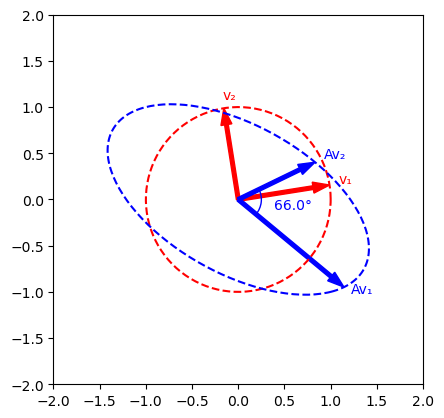

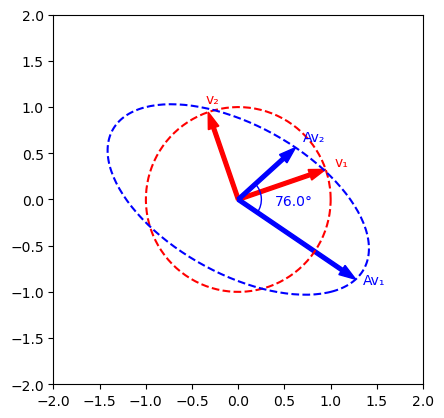

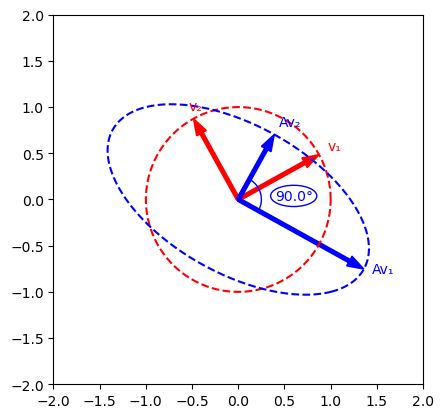

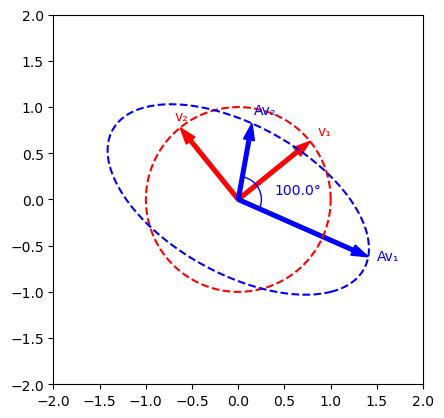

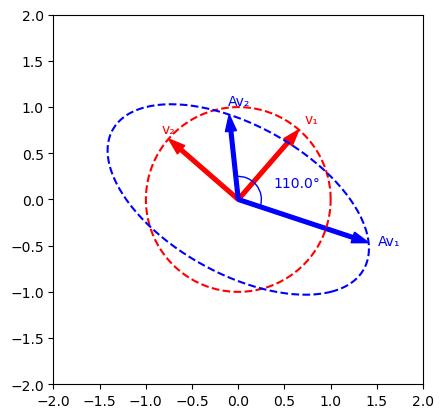

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /Users/stevenj/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


In [2]:
A = [1   1
    -1 1/4]
fig = figure()

Θ = range(0,2π, length=200)
V = [[cos(θ),sin(θ)] for θ in Θ]
U = [A*v for v in V]
Vx, Vy = first.(V), last.(V)
Ux, Uy = first.(U), last.(U)

# @manipulate for θ in slider(0:1:90, value=29)
for θ in 9:10:49
    display(
    withfig(fig) do
        ϕ = deg2rad(θ) # convert to radians
        v₁, v₂ = [cos(ϕ), sin(ϕ)], [-sin(ϕ), cos(ϕ)] # orthonormal inputs
        u₁, u₂ = A*v₁, A*v₂ # outputs
        
        # arrows and labels for v₁, v₂, u₁, u₂
        for (v,s,c) in ((v₁,"v₁","red"), (v₂,"v₂","red"), (u₁,"Av₁","blue"), (u₂,"Av₂","blue"))
            arrow(0,0,v..., color=c, width=0.04, length_includes_head=true)
            text(((norm(v)+0.1)*normalize(v))..., s, color=c)
        end
        
        # show the angle between u₁ and u₂
        uangle = rad2deg(acos((u₁⋅u₂)/(norm(u₁)*norm(u₂))))
        arc([0,0], 0.5,0.5, angle=rad2deg(atan(u₁[2],u₁[1])), theta1=0, theta2=uangle, color="blue")
        p = 0.4*normalize(u₁+u₂)
        text(p..., "$(round(uangle,sigdigits=2))°", color="blue")
        if round(uangle,sigdigits=2) == 90
            arc(p + [0.2,0.05], 0.5, 0.23, color="blue")
        end
        
        # plot dashed lines for all possible v₁, v₂, u₁, u₂
        
        plot(Vx,Vy, "r--")
        plot(Ux,Uy, "b--")
        
        axis("square")
        xlim(-2,2)
        ylim(-2,2)
    end
    )
end

### Some key observations:

* $A$ takes points $v_1, v_2$ on the unit circle and maps them to an *ellipse*.  In general ($n$ dimensions), linear tranformations map the unit sphere to an [ellipsoid](https://en.wikipedia.org/wiki/Ellipsoid).

* In general, even if $v_1 \perp v_2$, $Av_1$ and $Av_2$ are **not** orthogonal.

* However, for a **particular** choice of **orthonormal input basis**, we get **orthonormal outputs**.

## The “right” bases for A

In fact, it turns out that we can **always** do this for **any** $m \times n$ matrix $A$ of rank $r$:

* We can choose an orthonormal basis $v_1, v_2, \ldots , v_r \in \mathbb{R}^n$ of $C(A^T) = N(A)^\perp$ such that $Av_1, Av_2, \ldots, Av_r$ are an **orthogonal basis** for $C(A)$!!!

* To make an orthonormal basis for $C(A)$, we simply divide $Av_k$ etcetera by their lengths $\sigma_k = \Vert Av_k\Vert$ to get orthonormal vectors $u_k = Av_k /\sigma_k$.

* Geometrically, $A$ transforms spheres to ellipsoids with axes oriented along $u_k$ (the "principal axes"), and the "semi-axes" (half-diameters) of the ellipsoid are the $\sigma_k$.

(This is *not obvious*.  We won't have the tools to prove this, or to *find* these vectors, until later in 18.06.)

Equivalently:
$$
Av_k = \sigma_k u_k
$$
The matrix $A$ transforms orthormal vectors $v_k$ into orthonormal vectors $u_k$ "stretched" by the factors $\sigma_k$.

The $u_k$ and $v_k$ are called the **left and right singular vectors** and the $\sigma_k$ are called the **singular values**.  Together, they form the **singular value decomposition** (the **SVD**).

In particular, if we put the above relation in matrix form, we have:
$$
A \underbrace{ \begin{pmatrix} v_1 & \cdots & v_r \end{pmatrix} }_V =
\underbrace{ \begin{pmatrix} u_1 & \cdots & u_r \end{pmatrix} }_U
\underbrace{ \begin{pmatrix} \sigma_1 & & & \\
                              & \sigma_2 & & \\
                              & & \ddots & \\
                              & & & \sigma_r \end{pmatrix} }_\Sigma
$$

In fact, since $C(V)=C(A^T)=N(A)^\perp$, so that $N(V^T) = N(A)$, we can write:
$$
\boxed{A = U\Sigma V^T} = AVV^T = A[VV^T + \underbrace{(I-VV^T)}_{\mbox{proj. to }N(A)}]
$$
which is in the form of a matrix factorization, the SVD.

In Julia, you can get these vectors and values with the `svd` function:

In [3]:
U, σ, V = svd(A)
σ # the ellipsoid semi-axes

2-element Vector{Float64}:
 1.5542476415070756
 0.8042476415070755

In [4]:
V # columns of V are the orthogonal "input" basis v₁, v₂

2×2 adjoint(::Matrix{Float64}) with eltype Float64:
 -0.874642  -0.484769
 -0.484769   0.874642

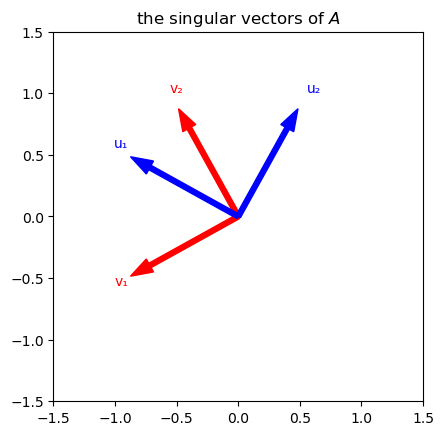

PyObject Text(0.5, 1.0, 'the singular vectors of $A$')

In [5]:
for (v,s,c) in ((V[:,1],"v₁","red"),  (V[:,2],"v₂","red"),
                (U[:,1],"u₁","blue"), (U[:,2],"u₂","blue"))
    arrow(0,0,v..., color=c, width=0.04, length_includes_head=true)
    text(((norm(v)+0.15)*normalize(v))..., s, color=c)
end
axis("square")
xlim(-1.5,1.5)
ylim(-1.5,1.5)
title(L"the singular vectors of $A$")

Modulo an arbitrary choice of sign ($v_1$ is flipped in sign), this is exactly the case of $\theta \approx 29^\circ$ that we found above which gave $Av_1 \perp Av_2$.  Julia has now computed a much more precise angle where this happens:

In [6]:
rad2deg(acos(-V[1,1]))  # rotation angle of the basis, in degrees

28.997308395958257

# Any matrix = sum of rank-1

The SVD $A = U\Sigma V^T$ can be thought of as: to compute $Ax$ for any $x$ you (1) compute $x$'s components in the $V$ basis with $V^Tx$, then (2) multiply each coefficient by the $\sigma_k$, and (3) add up in the $U$ basis.  In the SVD basis, any matrix $A$ acts like a bunch of **scalars** $\sigma_k$ once you have decomposed $x$ into the right **input and output basis**!

 - Note: are we missing anything when we compute $V^Tx$?  $V$ is only a basis for $C(A^T)$, so what happens if $x$ does not lie entirely in the row space of $A$?  Any remaining components $x$ must be in $C(A^T)^\perp = N(A)$, so $A$ would send those other components to zero!  So, to find out what $A$ does to any vector $x$, we **only need to know the components of x in the row space**.

This can be also written
$$
\boxed{A = \sigma_1 u_1 v_1^T + \sigma_2 u_2 v_2^T + \cdots + \sigma_r u_r v_r^T}
$$
That is, any matrix $A$ of rank $r$ can be written as a **sum of *r* rank-1 matrices** with orthogonal vectors, weighted by the singular values $\sigma$.

## Data “Compression”

It is conventional to sort the singular values in descending order
$$
\boxed{\sigma_1 \ge \sigma_2 \ge \cdots \ge \sigma_r}
$$
In this way, the earlier singular vectors describe the more "important" part of the matrix $A$: the part that has a bigger effect on the output of $Ax$.

Because the SVD **decomposes A into orthogonal components, sorted by "importance"** it is extremely useful in data analysis for pulling out the "most important" parts of a data.  There is a whole statistical technique, [principal component analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) that is based on this.

If we take only the **first k (< r) singular values** of $A$, we can think of it as an "approximate" version of A that throws out the "less important" parts.   This is called a [low-rank approximation](https://en.wikipedia.org/wiki/Low-rank_approximation) of a matrix:
$$
A \approx \sigma_1 u_1 v_1^T + \sigma_2 u_2 v_2^T + \cdots + \sigma_k u_k v_k^T
$$

A great way to visualize this is to look at **images**, which can be thought of as **matrices of numbers** representing the **red, green, and blue (RGB)** components of the image.

In [7]:
using Images, FileIO

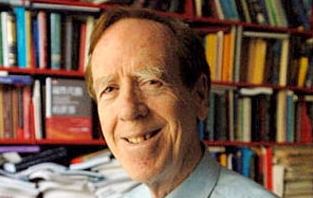

In [8]:
picture = download("http://web.mit.edu/jfrench/Public/gstrang.png")
pimage = load(picture)

In [9]:
p = Float64.(channelview(pimage)) # convert to an array
summary(p)

"3×198×313 Array{Float64, 3}"

In [10]:
pr,pg,pb = p[1,:,:],p[2,:,:],p[3,:,:]
Ur,σr,Vr = svd(pr)
Ug,σg,Vg = svd(pg)
Ub,σb,Vb = svd(pb);

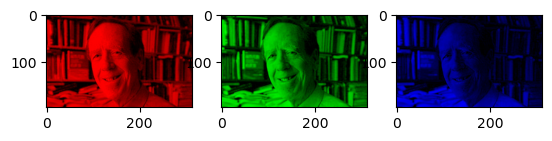

PyObject <matplotlib.image.AxesImage object at 0x7fd9e4c42f50>

In [11]:
subplot(1,3,1)
imshow(cat(pr,0*pg,0*pb, dims=3))
subplot(1,3,2)
imshow(cat(0*pr,pg,0*pb, dims=3))
subplot(1,3,3)
imshow(cat(0*pr,0*pg,pb, dims=3))

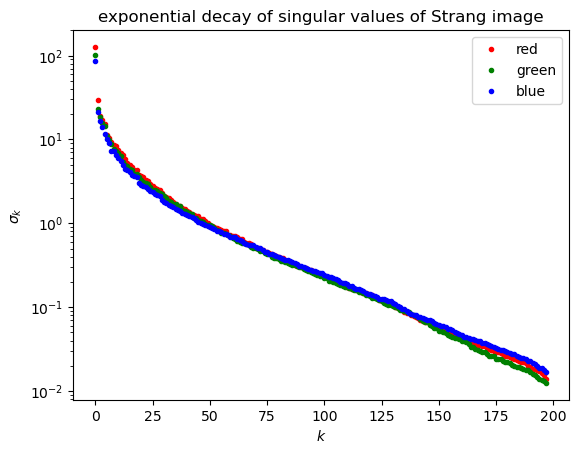

PyObject <matplotlib.legend.Legend object at 0x7fd9e6ed3050>

In [12]:
semilogy(σr, "r.")
semilogy(σg, "g.")
semilogy(σb, "b.")
title("exponential decay of singular values of Strang image")
ylabel(L"\sigma_k")
xlabel(L"k")
legend(["red","green","blue"])

In [13]:
# clip x to [0,1] so that imshow doesn't complain about rounding errors
# that lead to values slightly outside this range.
clip01(x) = max(min(x, 1), 0)

clip01 (generic function with 1 method)

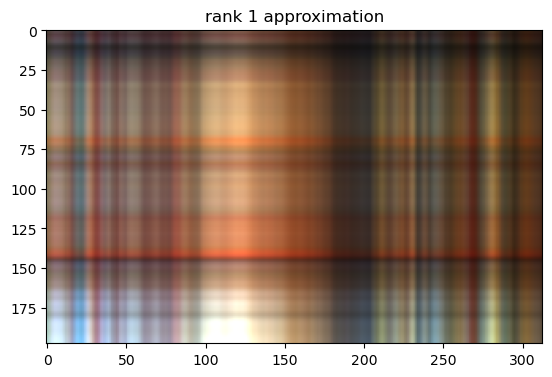

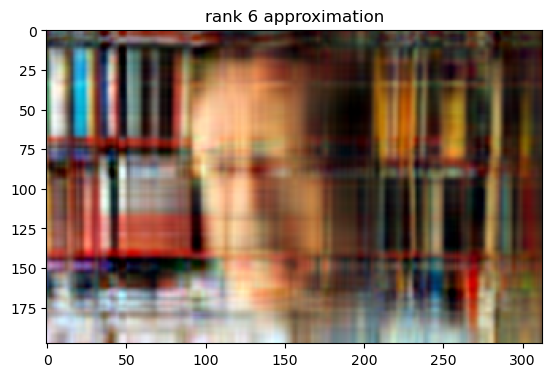

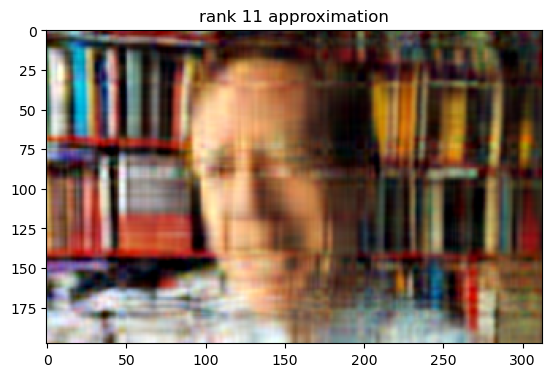

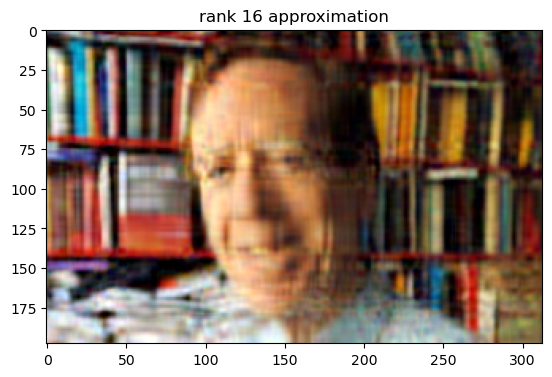

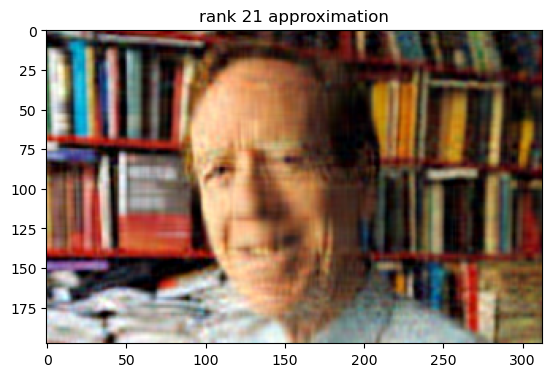

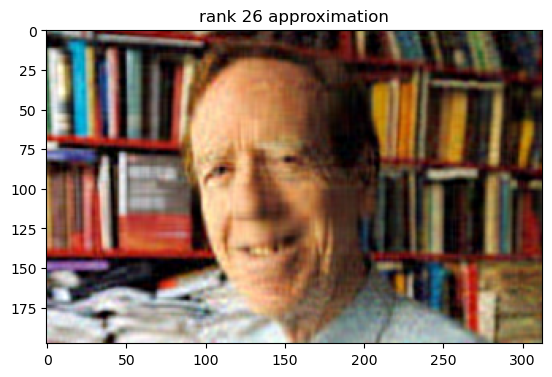

In [14]:
fig = figure()
# @manipulate for k=slider(1:40,value=1)
for k in 1:5:26
    display(
    withfig(fig) do
        title("rank $k approximation")
        p̂r = clip01.(Ur[:,1:k]*Diagonal(σr[1:k])*Vr[:,1:k]')
        p̂g = clip01.(Ug[:,1:k]*Diagonal(σg[1:k])*Vg[:,1:k]')
        p̂b = clip01.(Ub[:,1:k]*Diagonal(σb[1:k])*Vb[:,1:k]')
        imshow(cat(p̂r,p̂g,p̂b, dims=3))
    end
    )
end

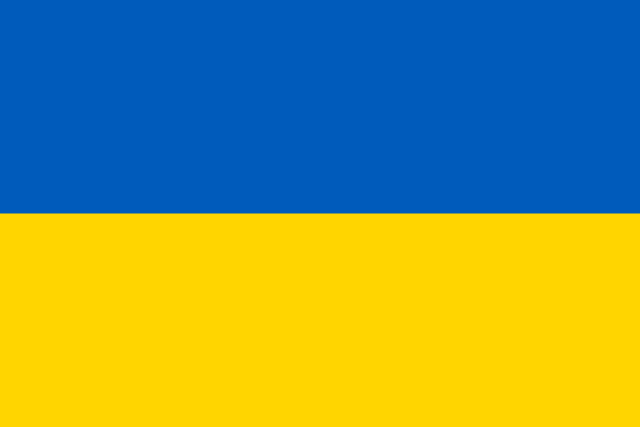

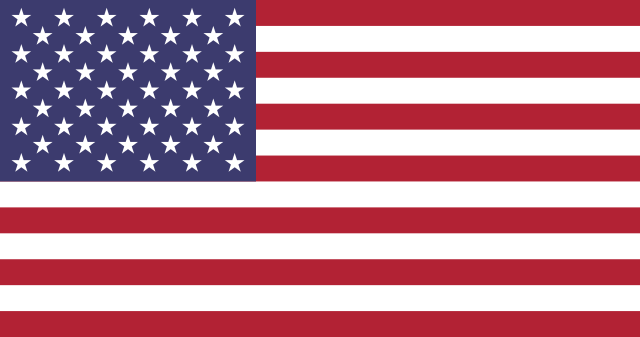

In [15]:
pics = Dict{String,Array}()
pics["Ukraine"] = load(download("https://upload.wikimedia.org/wikipedia/commons/thumb/4/49/Flag_of_Ukraine.svg/640px-Flag_of_Ukraine.svg.png"))
pics["USA"] = load(download("https://upload.wikimedia.org/wikipedia/en/thumb/a/a4/Flag_of_the_United_States.svg/640px-Flag_of_the_United_States.svg.png"))
# pics["Klingon"] = load(download("https://images-na.ssl-images-amazon.com/images/I/51ibu5dAb9L._SY550_.jpg"))
display(pics["Ukraine"])
display(pics["USA"])
# display(pics["Klingon"])

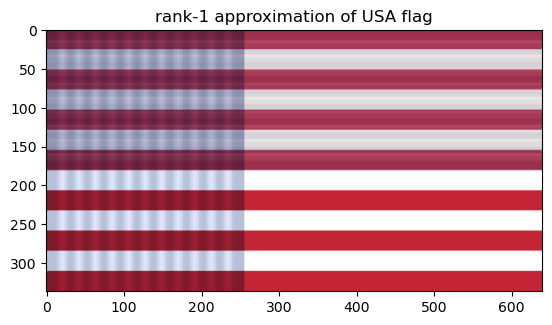

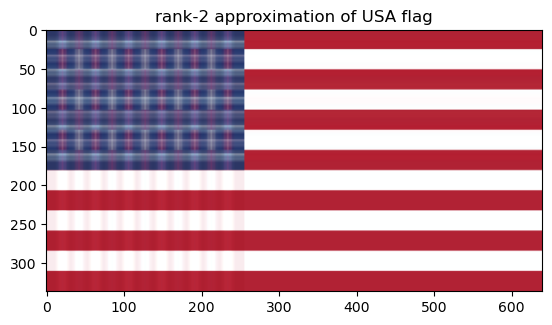

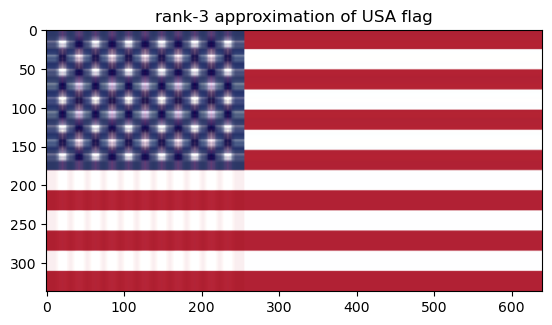

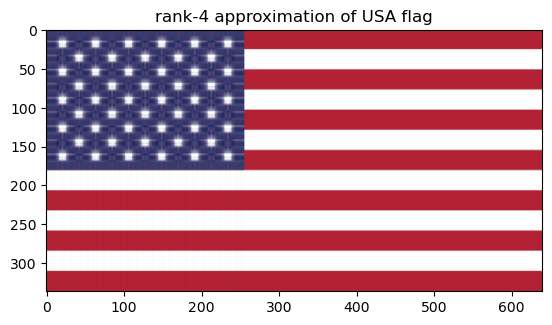

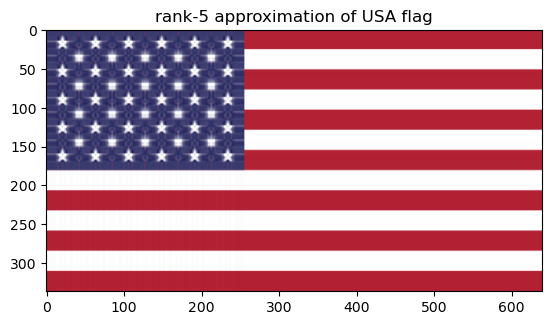

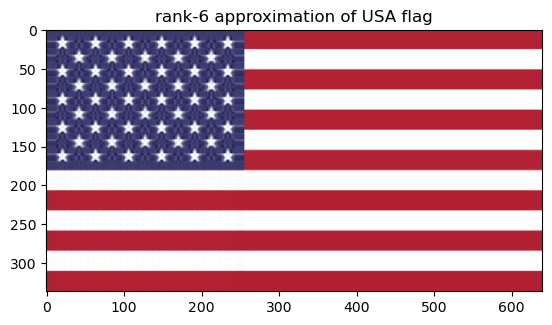

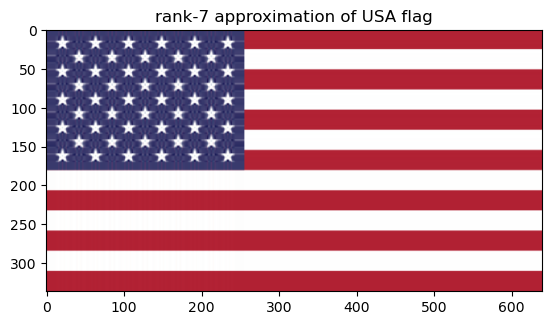

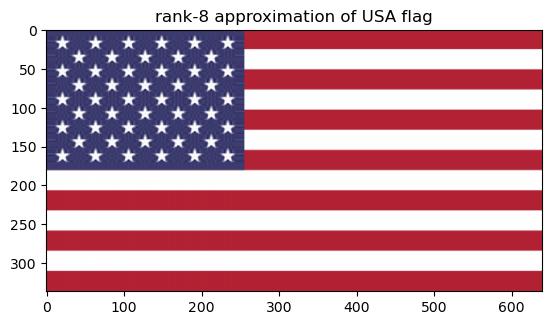

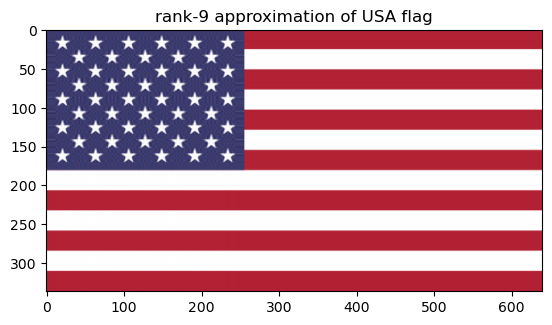

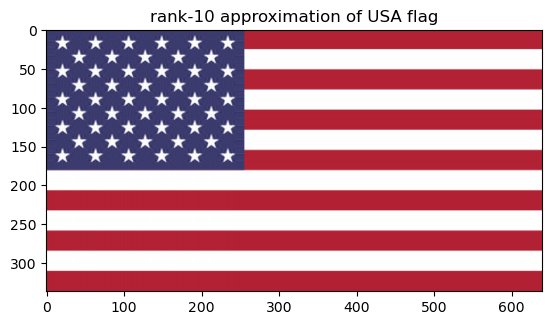

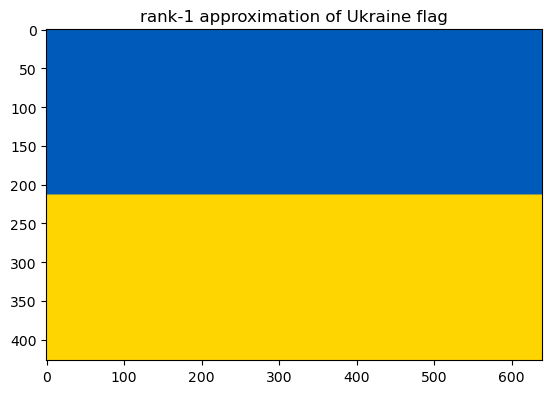

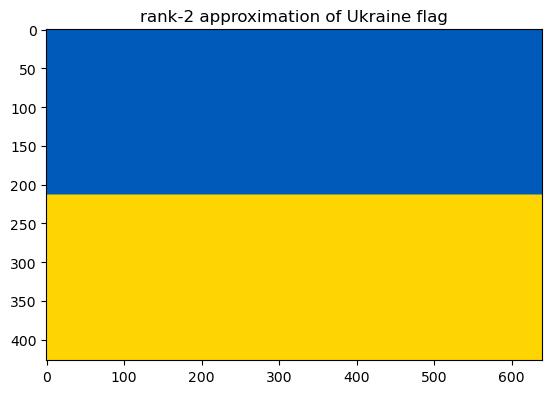

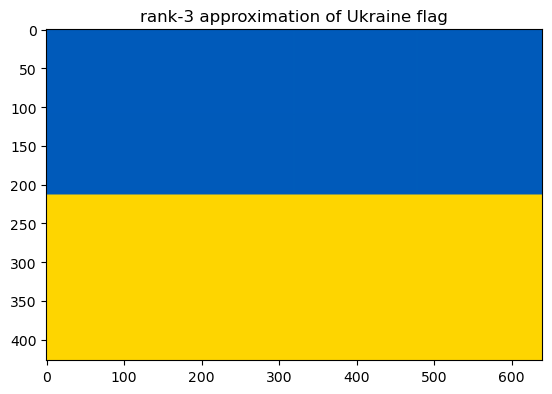

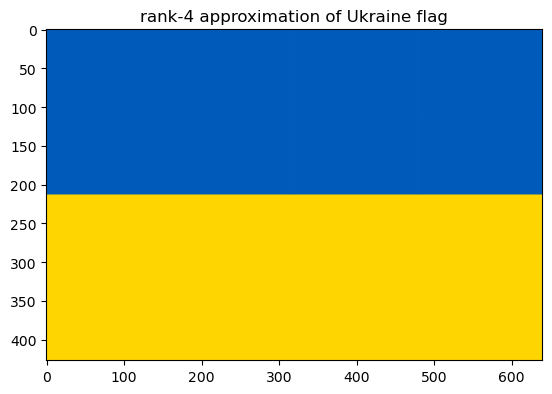

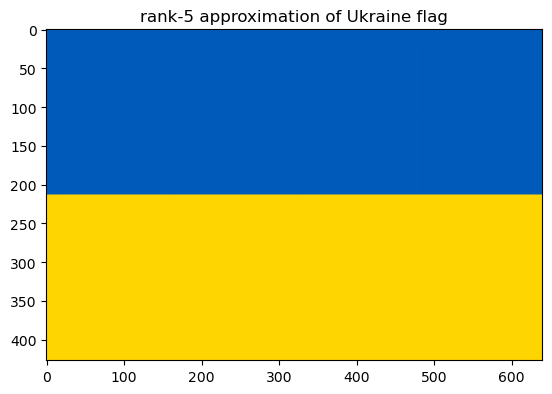

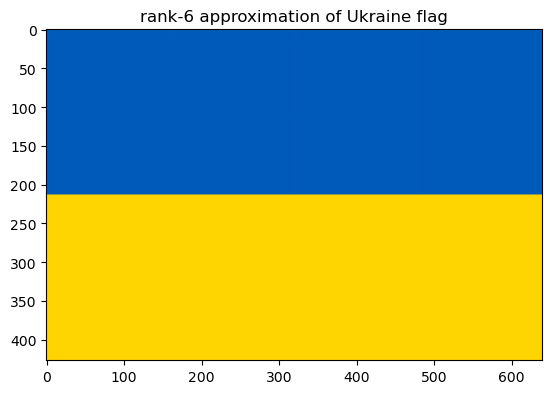

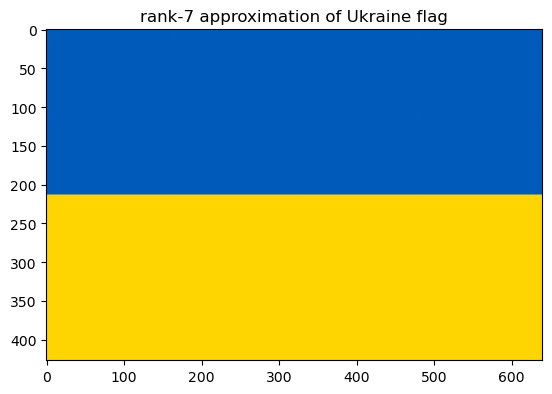

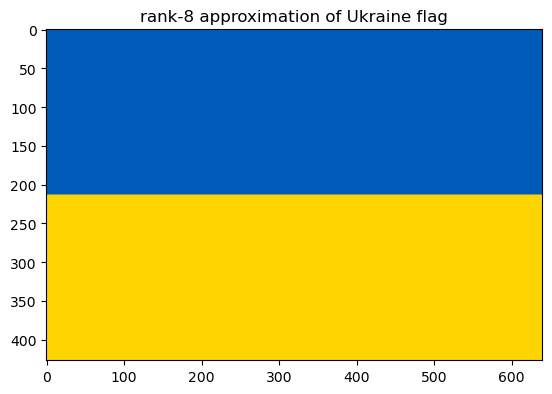

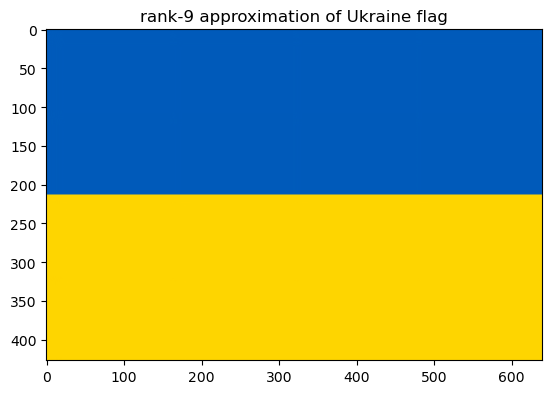

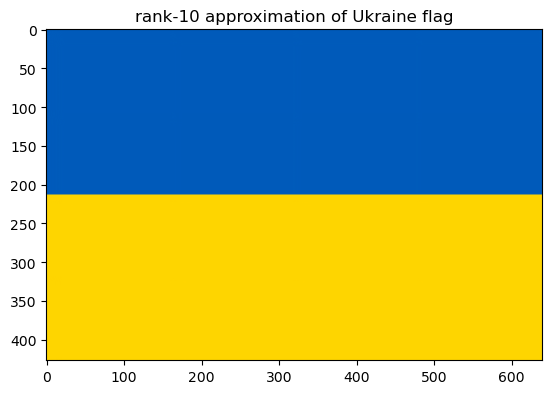

In [16]:
fig = figure()
# @manipulate for flagimg in collect(keys(pics)), k=slider(1:40,value=1)
for flagimg in collect(keys(pics)), k=1:10
  display(
    withfig(fig) do
        title("rank-$k approximation of $flagimg flag")
        p = float.(channelview(pics[flagimg])) # convert to an array
        pr,pg,pb = p[1,:,:],p[2,:,:],p[3,:,:]
        Ur,σr,Vr = svd(pr)
        Ug,σg,Vg = svd(pg)
        Ub,σb,Vb = svd(pb)
        p̂r = clip01.(Ur[:,1:k]*Diagonal(σr[1:k])*Vr[:,1:k]')
        p̂g = clip01.(Ug[:,1:k]*Diagonal(σg[1:k])*Vg[:,1:k]')
        p̂b = clip01.(Ub[:,1:k]*Diagonal(σb[1:k])*Vb[:,1:k]')
        imshow(cat(p̂r,p̂g,p̂b, dims=3))
    end
  )
end

Moral of the story: if *k* is large enough,
```
U[:,1:k] * Diagonal(σ[1:k]) * V[:,1:k]'
```
$$
= \sigma_1 u_1 v_1^T + \sigma_2 u_2 v_2^T + \cdots + \sigma_k u_k v_k^T
$$
is a good approximation to A often requiring less storage and less computation, revealing the "most important" parts of A.

# Nearly rank-deficient matrices

Consider the matrix
$$
B = \begin{pmatrix} 1 & 2 \\ 1 & 2.01 \end{pmatrix}
$$
The rows (and columns) of $B$ are *nearly* linearly dependent.  Maybe they were "supposed" to be *exactly* dependent but there was some error (e.g. measurement error) in constructing $B$.

The SVD of $B$ reveals that fact, because one of the singular values is much smaller than the other:

In [17]:
B = [1 2
     1 2.01]
σ = svdvals(B) # returns just the σ values

2-element Vector{Float64}:
 3.168610111694078
 0.0031559578640154287

We say that the matrix $B$ is **ill-conditioned**.  The **condition number** of a full-rank matrix is the ratio $\sigma_1 / \sigma_r = \sigma_\max / \sigma_\min$ of largest to smallest singular value.  It is computed in Julia by the `cond` function:

In [18]:
σ[1]/σ[2]

1004.0090039930228

In [19]:
cond(B) # same thing: the condition number of B

1004.0090039930228

If we plot what $B$ does to a circle, it *almost* projects it to a line.  The output ellipse is so thin we can't really see it is an ellipse.

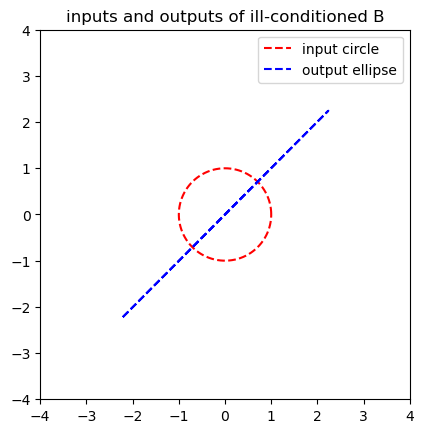

PyObject Text(0.5, 1.0, 'inputs and outputs of ill-conditioned B')

In [20]:
Θ = range(0,2π, length=200)
V = [[cos(θ),sin(θ)] for θ in Θ]
U = [B*v for v in V]
Vx, Vy = first.(V), last.(V)
Ux, Uy = first.(U), last.(U)
plot(Vx,Vy, "r--")
plot(Ux,Uy, "b--")

axis("square")
xlim(-4,4)
ylim(-4,4)
legend(["input circle", "output ellipse"])
title("inputs and outputs of ill-conditioned B")

So, $B$ is *almost* the rank-1 matrix $\tilde{B} = \sigma_1 u_1 v_1^T$:

In [21]:
U,σ,V = svd(B)
B̃ = σ[1] * U[:,1] * V[:,1]' # "best" rank-1 approximation to B

2×2 Matrix{Float64}:
 0.997999  2.001
 1.00199   2.00901

In [22]:
B̃ - B

2×2 Matrix{Float64}:
 -0.00200098   0.000997992
  0.00199301  -0.000994014

What happens if we blindly try to solve $Bx = b$ without knowing this fact?

First, because $B$ is nearly singular, $x = B^{-1} b$ tends to be pretty large for most $b$: we *almost* divided by zero:

In [23]:
x = B \ [1, 2]

2-element Vector{Float64}:
 -199.00000000000426
  100.00000000000213

Second, the **result can be hugely sensitive** to **small changes in b**:

In [24]:
B \ [1, 1]

2-element Vector{Float64}:
 1.0
 0.0

In [25]:
B \ [1, 1.01]

2-element Vector{Float64}:
 -1.0000000000000444
  1.0000000000000222

This is a general problem with "ill-conditioned" (nearly singular) systems of equations: the results can be **very sensitive** to **tiny errors** in the inputs (or to **tiny roundoff errors** during the computation).